# Regrid the dataset

In this notebook we will explore how to regrid the raw data to our target resolution. 

Currently we are thinking of doing a 1 degree resolution in the horizontal so a factor 4 for each side.

We will leave the vertical coordinate the same for now.

We are using xESMF: https://xesmf.readthedocs.io/en/latest/Rectilinear_grid.html

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tqdm

/home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Load the data

In [2]:
data_2d = xr.open_zarr("/home/noahb/data/2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute/2d.zarr/")
data_3d = xr.open_zarr("/home/noahb/data/2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute/3d.zarr/")

In [3]:
# For xESMF to work we need to rename the coordinates to lat and lon
data_2d = data_2d.rename({'grid_xt': 'lon', 'grid_yt': 'lat'})
data_3d = data_3d.rename({'grid_xt': 'lon', 'grid_yt': 'lat'})

In [4]:
data_2d.lon

<xarray.DataArray 'lon' (lon: 1536)>
array([1.171875e-01, 3.515625e-01, 5.859375e-01, ..., 3.594141e+02,
       3.596484e+02, 3.598828e+02], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.1171875 0.3515625 0.5859375 ... 359.64844 359.8828
Attributes:
    bounds:          grid_xt_bnds
    cartesian_axis:  X
    long_name:       T-cell longitude
    units:           degrees_E

In [5]:
data_2d.lat

<xarray.DataArray 'lat' (lat: 768)>
array([-89.88281, -89.64844, -89.41406, ...,  89.41406,  89.64844,  89.88281],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88281 -89.64844 -89.41406 ... 89.64844 89.88281
Attributes:
    bounds:          grid_yt_bnds
    cartesian_axis:  Y
    long_name:       T-cell latitude
    units:           degrees_N

`lon` and `lat` contain the lon/lat values at the centers of the 0.234375 degree wide grid boxes.

## Create a new dataset with a coarser grid.

In [6]:
ddeg = 0.234375
ddeg_out = ddeg * 4
ddeg_out

0.9375

In [7]:
1536 / 4, np.arange(ddeg_out/2, 360, ddeg_out).shape

(384.0, (384,))

In [8]:
768 / 4, np.arange(-90+ddeg_out/2, 90, ddeg_out).shape

(192.0, (192,))

In [9]:
ds_out = xr.Dataset({
    'lon': (['lon'], np.arange(ddeg_out/2, 360, ddeg_out)),
    'lat': (['lat'], np.arange(-90+ddeg_out/2, 90, ddeg_out))
})

In [10]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 384)
Coordinates:
  * lon      (lon) float64 0.4688 1.406 2.344 3.281 ... 356.7 357.7 358.6 359.5
  * lat      (lat) float64 -89.53 -88.59 -87.66 -86.72 ... 87.66 88.59 89.53
Data variables:
    *empty*

## Regrid - 2D case

In [11]:
import xesmf as xe

In [12]:
regridder = xe.Regridder(data_2d, ds_out, 'bilinear', )
regridder

Create weight file: bilinear_768x1536_192x384.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x1536_192x384.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 1536) 
Output grid shape:          (192, 384) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [13]:
t2m_re = regridder(data_2d.t2m)

/home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/xarray/core/dataarray.py:219: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [14]:
t2m_re

<xarray.DataArray 't2m' (time: 48, lat: 192, lon: 384)>
array([[[223.648295, 223.663275, ..., 223.627314, 223.639594],
        [222.88872 , 222.881545, ..., 222.881693, 222.8874  ],
        ...,
        [275.180298, 275.155548, ..., 275.192398, 275.187691],
        [274.923707, 274.915948, ..., 274.934655, 274.928658]],

       [[223.620753, 223.638327, ..., 223.597487, 223.61138 ],
        [222.783404, 222.771296, ..., 222.801817, 222.793573],
        ...,
        [275.075676, 275.074265, ..., 275.058296, 275.070305],
        [274.81115 , 274.807061, ..., 274.81762 , 274.815011]],

       ...,

       [[224.792507, 224.821118, ..., 224.746281, 224.771317],
        [223.395401, 223.448978, ..., 223.312543, 223.359593],
        ...,
        [274.88266 , 274.866524, ..., 274.907456, 274.892624],
        [274.324929, 274.312805, ..., 274.344284, 274.334923]],

       [[224.849281, 224.884068, ..., 224.791763, 224.823749],
        [223.349137, 223.414486, ..., 223.256387, 223.299237],
    

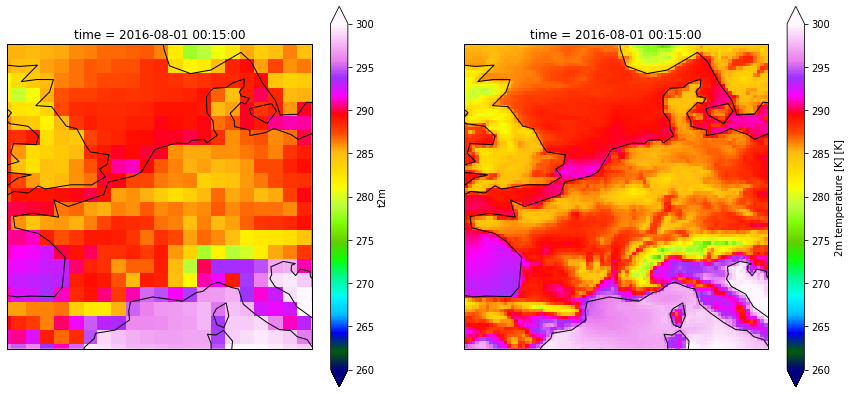

In [15]:
fig = plt.figure(figsize=(15, 7))
ax = plt.subplot(121, projection=ccrs.PlateCarree())
ax.set_extent([-5, 15, 40, 60])
t2m_re.isel(time=0).plot.pcolormesh(ax=ax, cmap='gist_ncar', vmin=260, vmax=300);
ax.coastlines();

ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
ax2.set_extent([-5, 15, 40, 60])
data_2d.t2m.isel(time=0).plot.pcolormesh(ax=ax2, cmap='gist_ncar', vmin=260, vmax=300);
ax2.coastlines();

## Regrid - 3D case

In [16]:
w_re = regridder(data_3d.w)

/home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/xarray/core/dataarray.py:219: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [17]:
w_re

<xarray.DataArray 'w' (time: 4, pfull: 79, lat: 192, lon: 384)>
array([[[[-8.195955e-02, ..., -8.210741e-02],
         ...,
         [-1.850590e-02, ..., -1.912381e-02]],

        ...,

        [[-4.274875e-03, ..., -4.168911e-03],
         ...,
         [-1.238306e-04, ..., -2.220997e-04]]],


       ...,


       [[[ 1.318853e-02, ...,  1.687580e-02],
         ...,
         [-2.168161e-02, ..., -2.159996e-02]],

        ...,

        [[-2.737651e-03, ..., -2.727604e-03],
         ...,
         [-1.048622e-06, ...,  1.831041e-05]]]])
Coordinates:
  * lon      (lon) float64 0.4688 1.406 2.344 3.281 ... 356.7 357.7 358.6 359.5
  * lat      (lat) float64 -89.53 -88.59 -87.66 -86.72 ... 87.66 88.59 89.53
  * time     (time) object 2016-08-01 03:00:00 ... 2016-08-01 12:00:00
  * pfull    (pfull) float32 4.5137978 8.300872 12.451992 ... 994.3374 998.2764
Attributes:
    regrid_method:  bilinear

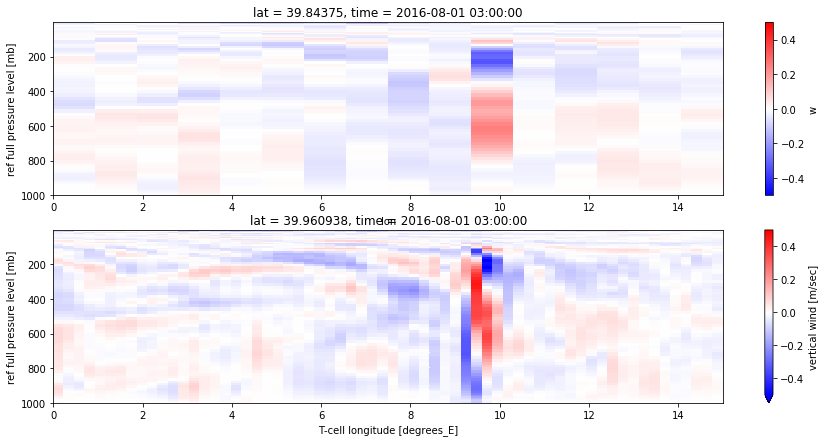

In [18]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 7))
w_re.sel(lat=40, method='nearest').sel(lon=slice(0, 15)).isel(time=0).plot(
    ax=ax, vmin=-0.5, vmax=0.5, cmap='bwr', yincrease=False)
data_3d.w.sel(lat=40, method='nearest').sel(lon=slice(0, 15)).isel(time=0).plot(
    ax=ax2, vmin=-0.5, vmax=0.5, cmap='bwr', yincrease=False)

## Now regrid the entire dataset

So this basically means regridding each variable and then merging them again in a dataset.

For this we have a function in `src.data.regrid`

In [2]:
from src.data.regrid import regrid_horizontal

In [3]:
data_2d = xr.open_zarr("/home/noahb/data/2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute/2d.zarr/")
data_3d = xr.open_zarr("/home/noahb/data/2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute/3d.zarr/")

In [4]:
ddeg = data_2d.grid_xt.diff('grid_xt').values[0]; ddeg

0.234375

In [ ]:
data_2d_re = regrid_horizontal(data_2d, ddeg*4)

In [8]:
data_2d_re.to_zarr('/home/rasp/data/data_2d_regridded.zarr', 'w')

In [ ]:
data_3d_re = regrid_horizontal(data_3d, ddeg*4)

In [6]:
data_3d_re.to_zarr('/home/rasp/data/data_3d_regridded.zarr', 'w')

In [7]:
data_2d_re

NameError: name 'data_2d_re' is not defined

In [8]:
data_3d_re

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 384, pfull: 79, plev: 31, time: 4)
Coordinates:
  * lon      (lon) float64 0.4688 1.406 2.344 3.281 ... 356.7 357.7 358.6 359.5
  * lat      (lat) float64 -89.53 -88.59 -87.66 -86.72 ... 87.66 88.59 89.53
  * time     (time) object 2016-08-01 03:00:00 ... 2016-08-01 12:00:00
  * plev     (plev) float32 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1000.0
  * pfull    (pfull) float32 4.5137978 8.300872 12.451992 ... 994.3374 998.2764
Data variables:
    h_plev   (time, plev, lat, lon) float64 -0.002621 -0.002515 ... 71.52 71.49
    pres     (time, pfull, lat, lon) float64 451.4 451.4 ... 1.007e+05 1.007e+05
    q_plev   (time, plev, lat, lon) float64 3.742e-06 3.742e-06 ... 0.004336
    qi       (time, pfull, lat, lon) float64 0.0 0.0 0.0 ... 1e-10 1e-10 1e-10
    qi_plev  (time, plev, lat, lon) float64 0.0 0.0 0.0 ... 1e-10 1e-10 1e-10
    ql       (time, pfull, lat, lon) float64 0.0 0.0 0.0 ... 9.178e-06 9.615e-06
    ql_plev  (time, plev, lat